In [1]:
!pip install pydub

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import hilbert, find_peaks, resample
from pydub import AudioSegment
from pydub.playback import play
import ipywidgets as widgets
from IPython.display import display

In [3]:
def load_audio(file_path):
    samplerate, data = wavfile.read(file_path)
    return samplerate, data

def analyze_audio(file_path):
    samplerate, data = load_audio(file_path)
    analytic_signal = hilbert(data)
    amplitude_envelope = np.abs(analytic_signal)

    fft_result = np.fft.fft(data)
    fft_freqs = np.fft.fftfreq(len(fft_result), 1/samplerate)

    ultrasonic_freqs = fft_freqs[(fft_freqs > 20000) & (fft_freqs < 40000)]
    ultrasonic_magnitudes = np.abs(fft_result[(fft_freqs > 20000) & (fft_freqs < 40000)])

    return samplerate, data, ultrasonic_freqs, ultrasonic_magnitudes, amplitude_envelope

def detect_suspicious_file(file_paths):
    max_magnitude = 0
    suspicious_file = None

    for file_path in file_paths:
        _, _, _, ultrasonic_magnitudes, _ = analyze_audio(file_path)
        if np.max(ultrasonic_magnitudes) > max_magnitude:
            max_magnitude = np.max(ultrasonic_magnitudes)
            suspicious_file = file_path

    return suspicious_file

def extract_and_play_code(file_path):
    samplerate, data, ultrasonic_freqs, ultrasonic_magnitudes, _ = analyze_audio(file_path)

    peaks, _ = find_peaks(ultrasonic_magnitudes, height=np.max(ultrasonic_magnitudes) * 0.5)

    if len(peaks) == 0:
        print("No significant peaks found in the ultrasonic range.")
        return

    ultrasonic_signal = np.zeros_like(data, dtype=float)
    for peak in peaks:
        freq = ultrasonic_freqs[peak]
        ultrasonic_signal += np.sin(2 * np.pi * freq * np.arange(len(data)) / samplerate)

    # Downsampling the signal to bring it into the audible range
    downsampled_signal = resample(ultrasonic_signal, len(ultrasonic_signal) // 10)

    # Normalizing the downsampled signal
    downsampled_signal = np.int16(downsampled_signal / np.max(np.abs(downsampled_signal)) * 32767)

    # Saving the downsampled signal as a wav file
    wavfile.write("decoded_secret_code.wav", samplerate // 10, downsampled_signal)

    sound = AudioSegment(downsampled_signal.tobytes(), frame_rate=samplerate // 10, sample_width=downsampled_signal.dtype.itemsize, channels=1)
    play(sound)

def plot_ultrasonic_frequencies(file_path):
    samplerate, data, ultrasonic_freqs, ultrasonic_magnitudes, _ = analyze_audio(file_path)

    plt.figure(figsize=(10, 6))
    plt.plot(ultrasonic_freqs, ultrasonic_magnitudes)
    plt.title("Ultrasonic Frequencies in the Suspicious File")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.show()

def on_button_click(b):
    suspicious_file = detect_suspicious_file(file_paths)
    output_text.value = f"Suspicious file detected: {suspicious_file}"

    plot_ultrasonic_frequencies(suspicious_file)
    extract_and_play_code(suspicious_file)

Button(description='Detect and Analyze', style=ButtonStyle())

Text(value='')

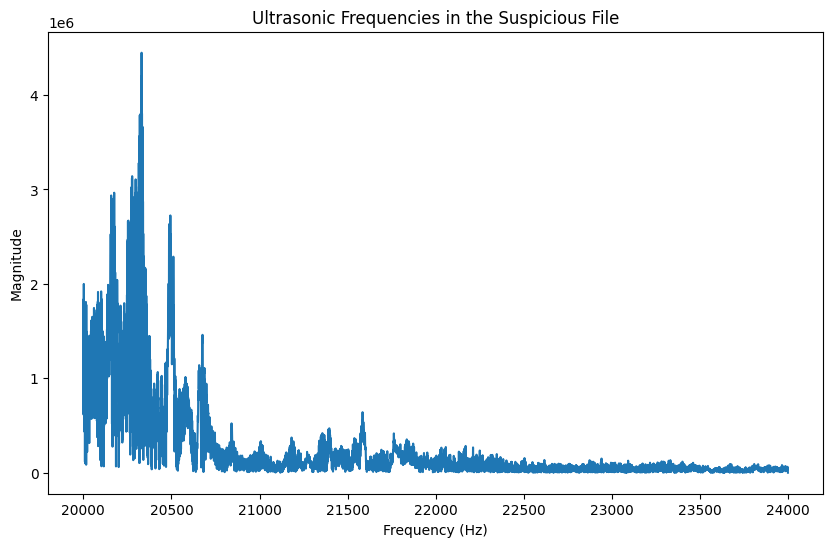

In [4]:
# Define the file paths to be analyzed (user can change these values)
file_paths = [
    '/content/drive/MyDrive/ISP_wavs/Ex3_sound2.wav',
    '/content/drive/MyDrive/ISP_wavs/Ex3_sound3.wav',
    '/content/drive/MyDrive/ISP_wavs/Ex3_sound4.wav'
]

# UI components
button = widgets.Button(description="Detect and Analyze")
output_text = widgets.Text()

button.on_click(on_button_click)

# Display UI components
display(button, output_text)